This notebook simulates accelerometer data, then feeds it to a model that predicts our position.

Measurement model: relates measurements to state at a given time. Model is $\text{Pr}(\mathbf{x}_t|\mathbf{w}_t)$.

Temporal model: describes relationship between adjacent states. Make the Markov assumption such that $\text{Pr}(\mathbf{w}_t | \mathbf{w}_{t-1})$


For inference we apply Bayes' rule
$$
    \text{Pr}(\mathbf{w}_1|\mathbf{x}_{1...t}) = \frac{\text{Pr}(\mathbf{x}_t | \mathbf{w}_t) \cdot \text{Pr}(\mathbf{w}_t | \mathbf{x}_{1...t-1})}{\text{Pr}(\mathbf{x}_{1...t})}
$$

Where the first term in the numerator is given by our generative model and the second term is computed using the Chapman-Kolmogorov relation, which exploits the Markov assumption and our inference for the previous time-step:
$$
    \text{Pr}(\mathbf{w}_t|\mathbf{x}_{1...t-1}) = \int \text{Pr}(\mathbf{w}_t|\mathbf{w}_{t-1}) \cdot \text{Pr}(\mathbf{w}_{t-1}|\mathbf{x}_{1...t-1}) \cdot d\textbf{w}_{t-1}
$$

Consequently we can see that inference consists of two steps:
1. Compute the current prior on the world state using the Chapman-Kolmogorov relation.
2. Compute the current posterior using Bayes' rule.


The parameters in our model parameterise the relationship between adjacent world states and the world state and observed data. In our case the world state variable is a vector containing three elements: displacement, velocity, and acceleration. Because we don't know the 'true' position of the razor, we must treat it as a hidden variable (i.e. a variable that has a realized value, but one that we are not sure of). Fitting the model therefore consists of alternating between estimating the hidden variables and the parameters for the model.


##### Temporal model
The temporal model relates adjacent world states. It is quite simple: a linear function of the previous world state, plus some noise, and a mean change:

$$
    \mathbf{w}_t = \mathbf{\mu}_{p} + \mathbf{\Psi}\mathbf{w}_{t-1} + \mathbf{\epsilon}_{p}
$$

The linear transformation matrix is known as the transition matrix - it relates the mean state at time $t$ to the mean state at time $t-1$. Since we assume the noise is Gaussian, we can express the above relationship as:

$$
    \text{Pr}(\mathbf{w}_t | \mathbf{w}_{t-1}) = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{w}_{t-1}, \mathbf{\Sigma}_p]
$$

Note that the covariance matrix doesn't necessarily have to be spherical or diagonal - we can express correlations between various forms of noise.


##### Measurement model
The measurement model relates the measurements to the world state. It also takes the form of an affine function.

$$
    \mathbf{x}_t = \mathbf{\mu}_{m} + \mathbf{\Phi}\mathbf{w}_{t} + \mathbf{\epsilon}_{m}
$$

Again, we can express this as a probability distribution:

$$
    \text{Pr}(\mathbf{x}_t | \mathbf{w}_{t}) = \text{Norm}_{\mathbf{x}_t}[\mathbf{\mu}_m + \mathbf{\Phi}\mathbf{w}_{t}, \mathbf{\Sigma}_m]
$$

By choosing both the prior (i.e. the temporal model) and the likelihood (the measurement model) to be normal, we produce a conjugate relation that means the posterior (i.e. the distribution over the world state, given the measurements) is also normal.


##### Inference
Inference consists of recursively computing the measurement distribution and the temporal distribution. In the prediction step we evaluate the Chapman-Kolmogorov equation to find the prior over the world state for the current time-step:

$$
    \text{Pr}(\mathbf{w}_t | \mathbf{x}_{1...t-1}) = \int \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{w}_{t-1}, \mathbf{\Sigma}_p] \cdot \text{Norm}_{\mathbf{w}_{t-1}}[\mathbf{\mu}_{t-1}, \mathbf{\Sigma}_{t-1}] \cdot d\mathbf{w}_{t-1}
$$

$$
    = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_p + \mathbf{\Psi}\mathbf{\mu_{t-1}}, \Sigma_p + \mathbf{\Psi}\Sigma_{t-1}\Psi^T]
$$

$$
    = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_{+}, \mathbf{\Sigma}_{+}]
$$

We then apply Bayes' rule for the posterior over the world state given the measurements. For notational convenience, we define the Kalman gain $\mathbf{K}$ as:

$$
    \mathbf{K} = \mathbf{\Sigma}_{+}\mathbf{\Phi}^T (\mathbf{\Sigma}_m + \mathbf{\Phi}\mathbf{\Sigma}_{+}\mathbf{\Phi}^T)^{-1}
$$

Where $\mathbf{\Phi}$ is the linear transformation matrix from the measurement model. The posterior over the world state given the measurements is then:

$$
    \text{Pr}(\mathbf{w}_t|\mathbf{x}_{1...t}) = \text{Norm}_{\mathbf{w}_t}[\mathbf{\mu}_t, \mathbf{\Sigma}_t]
$$

where:

$$
\mathbf{\mu}_t = \mathbf{\mu}_{+} + \mathbf{K}(\mathbf{x}_t - \mathbf{\mu}_m - \mathbf{\Phi}\mathbf{\mu}_{+})
$$

$$
    \mathbf{\Sigma}_t = (\mathbf{I} - \mathbf{K}\mathbf{\Phi})\mathbf{\Sigma}_{+}
$$

Both of these expressions can be understood as a weighting of the prior and the measured world states. The term in brackets for the mean is called the *innovation* - it corresponds to the difference between the predicted measurements and the actual measurements.

In [214]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Generate simulated path data

In [231]:
plt.style.use('ggplot')

PATH_RADIUS = 5
N_POINTS    = 50
TH_START    = -np.pi/2
TH_STOP     = np.pi
JITTER_SD   = 0.2
true_world_states = np.array([[PATH_RADIUS*np.cos(th), PATH_RADIUS*np.sin(th)]
                               for th in np.linspace(TH_START, TH_STOP, N_POINTS)])
jitter      = JITTER_SD*np.random.rand(N_POINTS, 2)
true_world_states += jitter

# 2. Associate some noisy absolute position measurements with this data

In [238]:
NOISE_SD = 2
measurement_noise = np.random.rand(N_POINTS, 2) - 0.5
measurements = true_world_states + NOISE_SD*measurement_noise

# 3. Apply the Kalman filter to the measurements

In [239]:
# BROWNIAN MOTION MODEL
#---------------------

# 1. Generate a smooth path.
# 2. Add Gaussian noise to the path to generate a set of 'measurements'.
# 3. Define \mu_{0} as the initial world state (i.e. calibrate).
# 4. Define \Sigma_{0} as a large multiple of the identity matrix.

# Prediction step
# 4. Estimate the prediction step mean, \mu_{+} => Mean world state, given previous world state
#    \mu_{+} = \mu_{t-1} for the Brownian motion model
# 5. Estimate the prediction step covariance, \Sigma_{+} => World state covariance, given previous world state
#    \Sigma_{+} = \Sigma_{p} + \Sigma_{t-1}


# State update step
# 6. Compute the Kalman gain, here:
#    K = \Sigma_{+} (\Sigma_m + \Sigma_{+})^{-1}
# 7. Update the current world state mean:
#    mu_{t} = \mu_{+} + K(x_t - \mu_{+})
# 8. Update the current world state variance:
#    \Sigma_{t} = (I - K) \Sigma_{+}

In [240]:
mu    = np.zeros([N_POINTS, 2]) # Mean positional estimate for each time-step
Sigma = np.zeros([N_POINTS, 2, 2]) # Mean variance estimate for each time-step

# Calibrate the initial position
mu[0, :]       = true_world_states[0, :]
Sigma[0, :, :] = 0.01*np.eye(2) # Small uncertainty in initial position

# Estimate the prediction and measurement parameters

# Prediction parameters
# In this model, we assume that the most likely position given the last is the last (i.e. zero mean change)
# For the variance of the model, we make an educated guess of 0.3
# This value can be thought of as a circle centered on the previous position that constrains the next most likely position.
Sigma_p = 0.6*np.eye(2) # We assume that movements in either direction are not correlated

# Identity mapping from the measurement to the world state, with  an estimated error of 2 (e.g. read from datasheet)
Sigma_m = 2*np.eye(2)

for t in range(1, N_POINTS):
    # > Prior prediction <
    # Predict the new mean position based on the last step alone
    mu_plus    = mu[t-1, :]
    
    # Predict the new variance based on the last step
    Sigma_plus = Sigma_p + Sigma[t-1, :, :]
    
    # > Measurement Incorporation <
    K              = np.matmul(Sigma_plus, np.linalg.inv(Sigma_m + Sigma_plus)) # Kalman gain
    mu[t, :]       = mu_plus + np.matmul(K, measurements[t, :] - mu_plus)
    Sigma[t, :, :] = np.matmul(np.eye(2) - K, Sigma_plus)

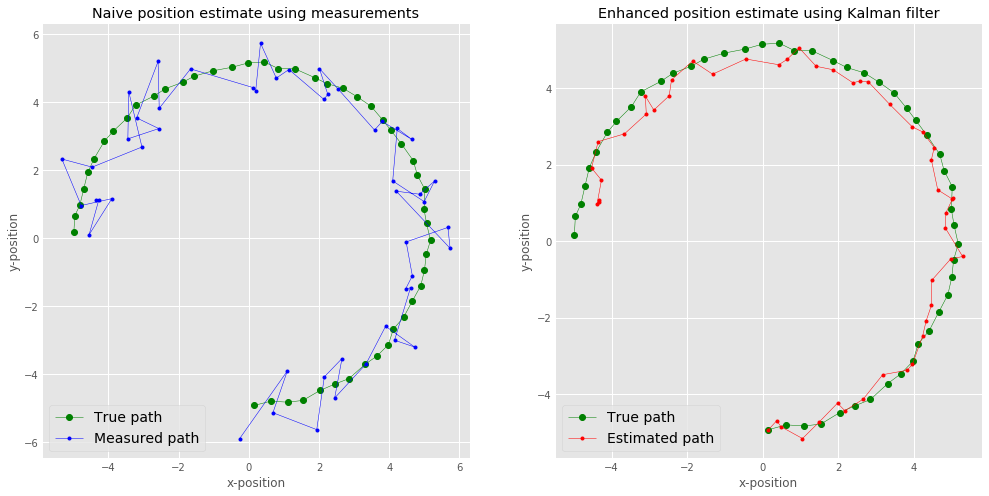

In [241]:
# Display the results

f, axs = plt.subplots(1, 2, figsize = (15, 8))
axs[0].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[0].plot(measurements[:, 0], measurements[:, 1], 'b.-', linewidth=0.5, label = 'Measured path')
axs[1].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[1].plot(mu[:, 0], mu[:, 1], 'r.-', linewidth=0.5, label = 'Estimated path')

axs[0].set_title('Naive position estimate using measurements')
axs[1].set_title('Kalman-filtered position estimate')

plt.title('Enhanced position estimate using Kalman filter')
for ax in axs:
    ax.set_xlabel('x-position')
    ax.set_ylabel('y-position')
    ax.legend(fontsize = 14, loc = 3)

We can see that the Kalman-filtered path estimate is markedly smoother, directionally consistent, and geometrically accurate. The remarkable thing about this model is that we make no assumptions about the nature of the underlying movement - even were the path being followed were sinusoidal (per se), the filter would perform similarly well. If we have knowledge of likely movements (e.g. approximately unidirectional razor blade movements) then we can vastly improve the accuracy of our estimates.

To incorporate this kind of understanding into our model, we make a dynamic estimate of the change in world state.

In [252]:
mu    = np.zeros([N_POINTS, 4])
Sigma = np.zeros([N_POINTS, 4, 4])

# Calibrate initial position
mu[0, :2]      = true_world_states[0, :2]
mu[0, 2:]      = 0 # Initial velocity
Sigma[0, :, :] = 0.01*np.eye(4)

# Initialize prediction/measurement variance, mean change
Sigma_p = 0.5*np.eye(4)          # Make an educated initial guess
Sigma_p[-1, -1] = 0.001
Sigma_p[-2, -2] = 0.001
phi_p   = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]]) 
# ^ Account for velocities in predicted positions

Sigma_m = 2*np.eye(2)      # Assume the measurements are v. noisy
phi_m   = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Measurements only relate to first two dimensions of prediction

# Iterate, updating the mean direction change on each step
for t in range(1, N_POINTS):
    # Predict new position based on previous position
    mu_plus    = np.matmul(phi_p, mu[t-1, :])
    Sigma_plus = Sigma_p + np.matmul(np.matmul(phi_p, Sigma[t-1, :, :]), phi_p.T)
    
    # Incorporate measurements into position estimate
    K              = np.matmul(np.matmul(Sigma_plus, phi_m.T),
                               np.linalg.inv(Sigma_m + 
                                             np.matmul(
                                                np.matmul(phi_m, Sigma_plus),
                                                phi_m.T)
                                            )
                              )
    mu[t, :]       = mu_plus + np.matmul(K, (measurements[t, :] - mu_m - np.matmul(phi_m, mu_plus)))
    Sigma[t, :, :] = np.matmul((np.eye(4) - np.matmul(K, phi_m)), Sigma_plus)

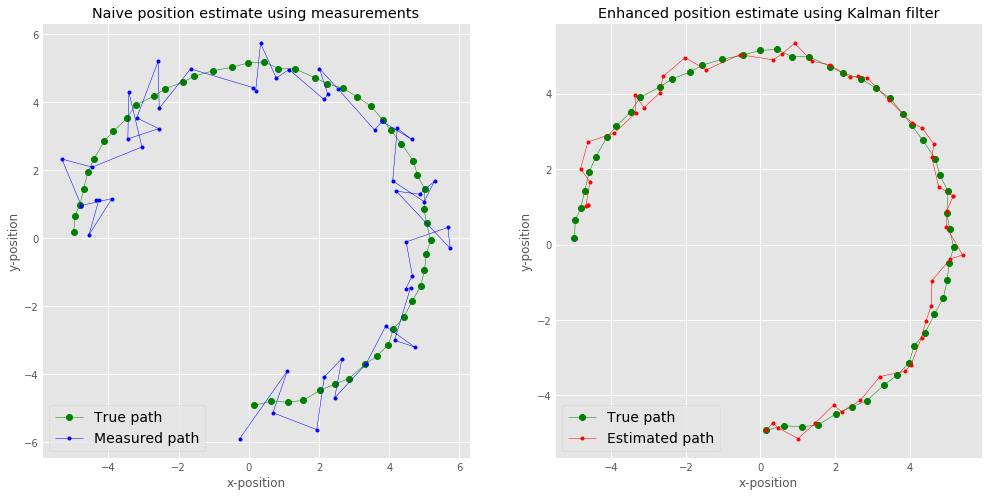

In [253]:
# Display the results

f, axs = plt.subplots(1, 2, figsize = (15, 8))
axs[0].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[0].plot(measurements[:, 0], measurements[:, 1], 'b.-', linewidth=0.5, label = 'Measured path')
axs[1].plot(true_world_states[:, 0], true_world_states[:, 1], 'go-', linewidth=0.5, label = 'True path')
axs[1].plot(mu[:, 0], mu[:, 1], 'r.-', linewidth=0.5, label = 'Estimated path')

axs[0].set_title('Naive position estimate using measurements')
axs[1].set_title('Kalman-filtered position estimate')

plt.title('Enhanced position estimate using Kalman filter')
for ax in axs:
    ax.set_xlabel('x-position')
    ax.set_ylabel('y-position')
    ax.legend(fontsize = 14, loc = 3)